## Erik Bayerlein - 537606

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean, mahalanobis

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Algorithms

#### Auxiliary Algorithms

In [123]:
def calculate_metrics(y_true, y_pred):
    y_true_flat = np.asarray(y_true)
    y_pred_flat = y_pred.flatten()
    
    return np.array([
        accuracy_score(y_true_flat, y_pred_flat),
        recall_score(y_true_flat, y_pred_flat, zero_division=0),
        precision_score(y_true_flat, y_pred_flat, zero_division=0),
        f1_score(y_true_flat, y_pred_flat, zero_division=0)
    ])

In [124]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    predictions = []
    metrics_fold = []
    
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions.append(pred)
        metrics_fold.append(calculate_metrics(y_test, pred))
    
    return predictions, metrics_fold

In [125]:
def create_heatmap(metrics_data, model_labels, colors, title, figsize=(18, 12)):
    metric_labels = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
    n_models = len(model_labels)
    
    fig, axes = plt.subplots(n_models, 3, figsize=figsize)
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_models):
        sns.heatmap(metrics_data[i], 
                    annot=True, 
                    fmt='.3f',
                    xticklabels=metric_labels, 
                    yticklabels=[f'Fold {j+1}' for j in range(10)],
                    cmap=colors[i],
                    cbar_kws={'shrink': 0.8},
                    ax=axes[i][0])
        
        sns.heatmap([np.mean(metrics_data[i], axis=0)], 
                    annot=True, 
                    fmt='.3f',
                    xticklabels=metric_labels,
                    yticklabels=['Mean'],
                    cmap=colors[i],
                    cbar_kws={'shrink': 0.8},
                    ax=axes[i][1])
        
        sns.heatmap([np.std(metrics_data[i], axis=0, ddof=1)], 
                    annot=True, 
                    fmt='.3f',
                    xticklabels=metric_labels,
                    yticklabels=['Std Dev'],
                    cmap='Greys',
                    cbar_kws={'shrink': 0.8},
                    ax=axes[i][2])
        
        if i == 0:
            axes[i][0].set_title('Metrics per Fold', fontsize=16, fontweight='bold')
            axes[i][1].set_title('Mean Metrics', fontsize=16, fontweight='bold')
            axes[i][2].set_title('Standard Deviation', fontsize=16, fontweight='bold')
        
        axes[i][0].set_ylabel(model_labels[i], fontsize=14, fontweight='bold')
        
        for ax in axes[i]:
            ax.tick_params(axis='x', rotation=45, labelsize=12)
            ax.tick_params(axis='y', rotation=0, labelsize=11)
    
    plt.tight_layout(pad=3.0)
    fig.suptitle(title, fontsize=18, fontweight='bold', y=0.95)
    plt.show()

#### K Nearest Neighbors

In [126]:
class KNearestNeighbors:
    def __init__(self, n_neighbors: int = 5, metric: str = 'euclidean') -> None:
        self.n_neighbors = n_neighbors
        assert metric in ['euclidean', 'mahalanobis'], "metric must be 'euclidean' or 'mahalanobis'"
        self.metric = metric
        self.X_train: np.ndarray = np.array([])
        self.y_train: np.ndarray = np.array([])
        self.cov: np.ndarray = np.array([])

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.cov = np.cov(X_train.T)

    def predict(self, X_test: np.ndarray):
        distances = np.zeros((X_test.shape[0], self.X_train.shape[0]))
        
        if self.metric == 'euclidean':
            for i in range(X_test.shape[0]):
                for j in range(self.X_train.shape[0]):
                    distances[i][j] = euclidean(X_test[i], self.X_train[j])
        else:
            for i in range(X_test.shape[0]):
                for j in range(self.X_train.shape[0]):
                    distances[i][j] = mahalanobis(X_test[i], self.X_train[j], np.linalg.pinv(self.cov))
        
        indexes = np.argpartition(distances, self.n_neighbors)
        neighbors = self.y_train[indexes[:, :(self.n_neighbors)]].reshape(X_test.shape[0], self.n_neighbors)
        result = np.zeros((neighbors.shape[0], 1))

        for i in range(neighbors.shape[0]):
            result[i] = np.argmax(np.bincount(neighbors[i].astype(int)))
        return result

------------

In [127]:
data = pd.read_csv('../../datasets/kc2.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

## Q1

### a.1) KNN

In [128]:
folder = KFold(n_splits=10, shuffle=True)
normalizer = StandardScaler()

In [129]:
knn_euc_1 = KNearestNeighbors(1, 'euclidean')
knn_euc_5 = KNearestNeighbors(5, 'euclidean')

knn_mah_1 = KNearestNeighbors(1, 'mahalanobis')
knn_mah_5 = KNearestNeighbors(5, 'mahalanobis')

In [130]:
models = [knn_euc_1, knn_euc_5, knn_mah_1, knn_mah_5]
metrics = np.zeros((4, 10, 4))

for i, (train_index, test_index) in enumerate(folder.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    _, fold_metrics = evaluate_models(models, X_train, X_test, y_train, y_test)
    
    for j, model_metrics in enumerate(fold_metrics):
        metrics[j][i] = model_metrics

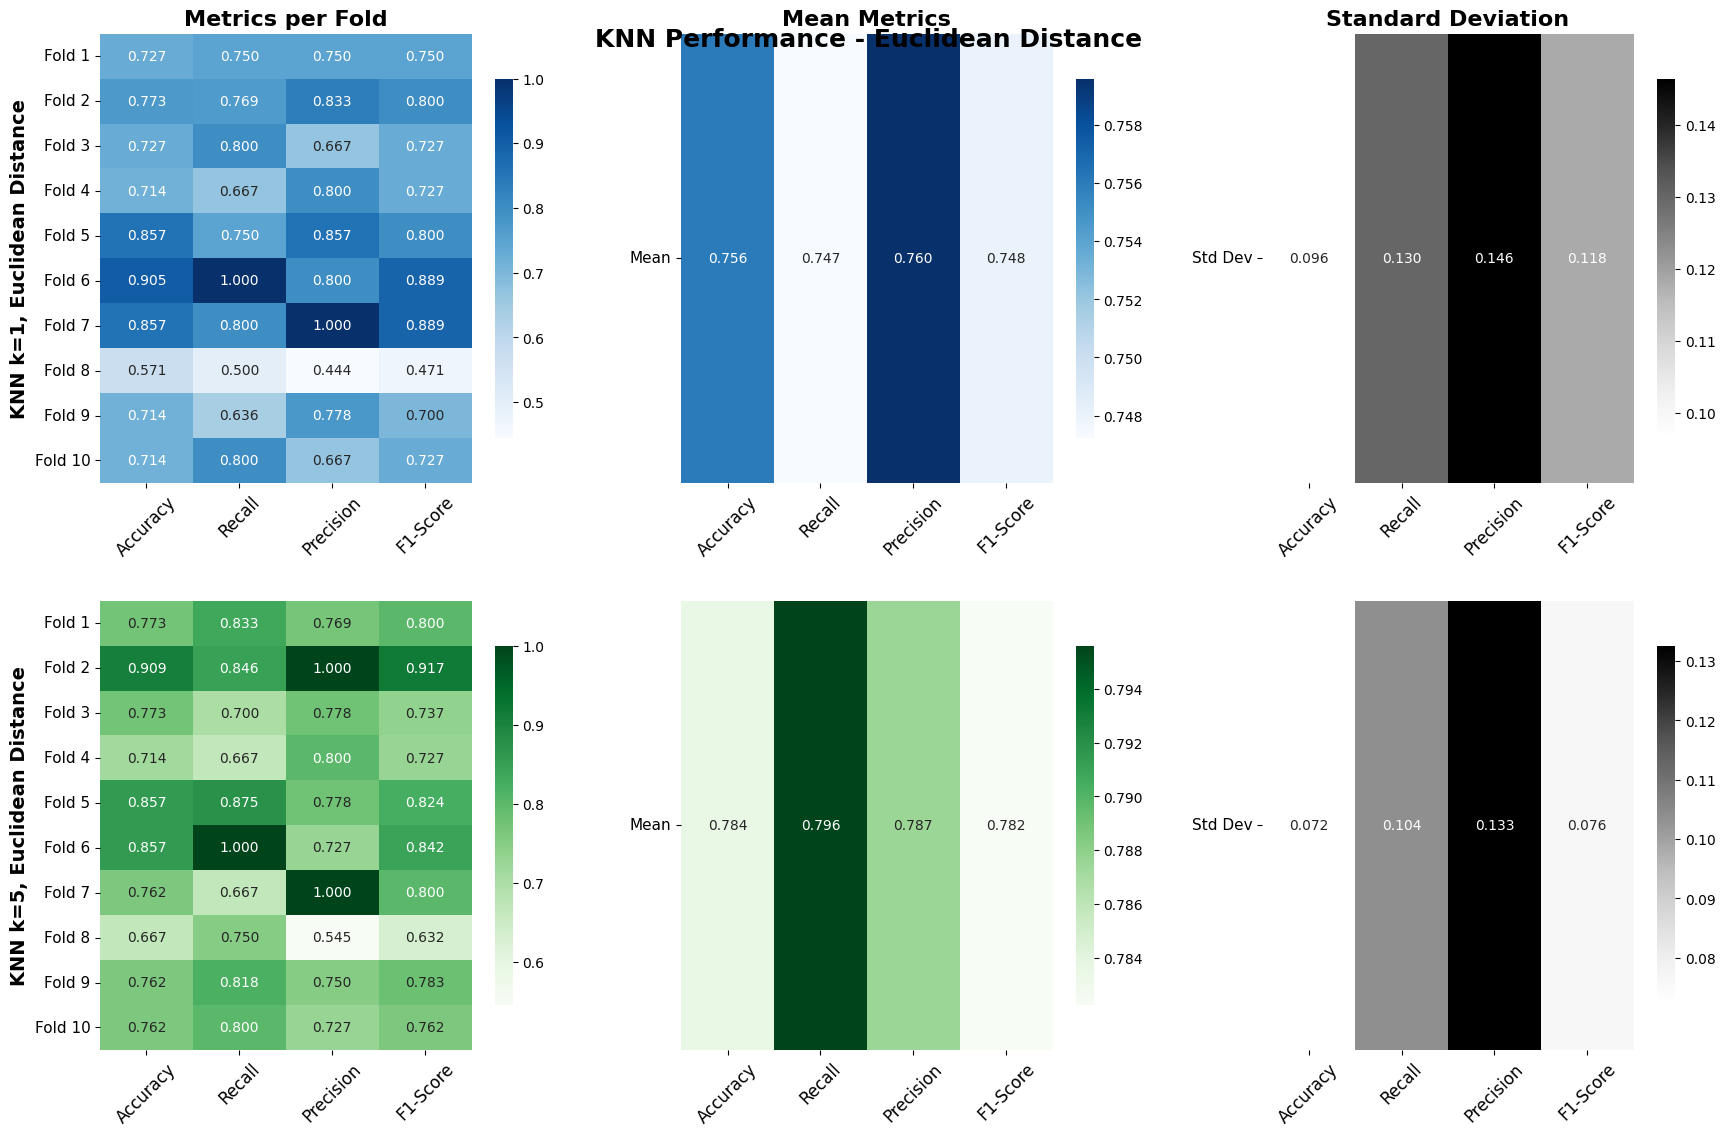

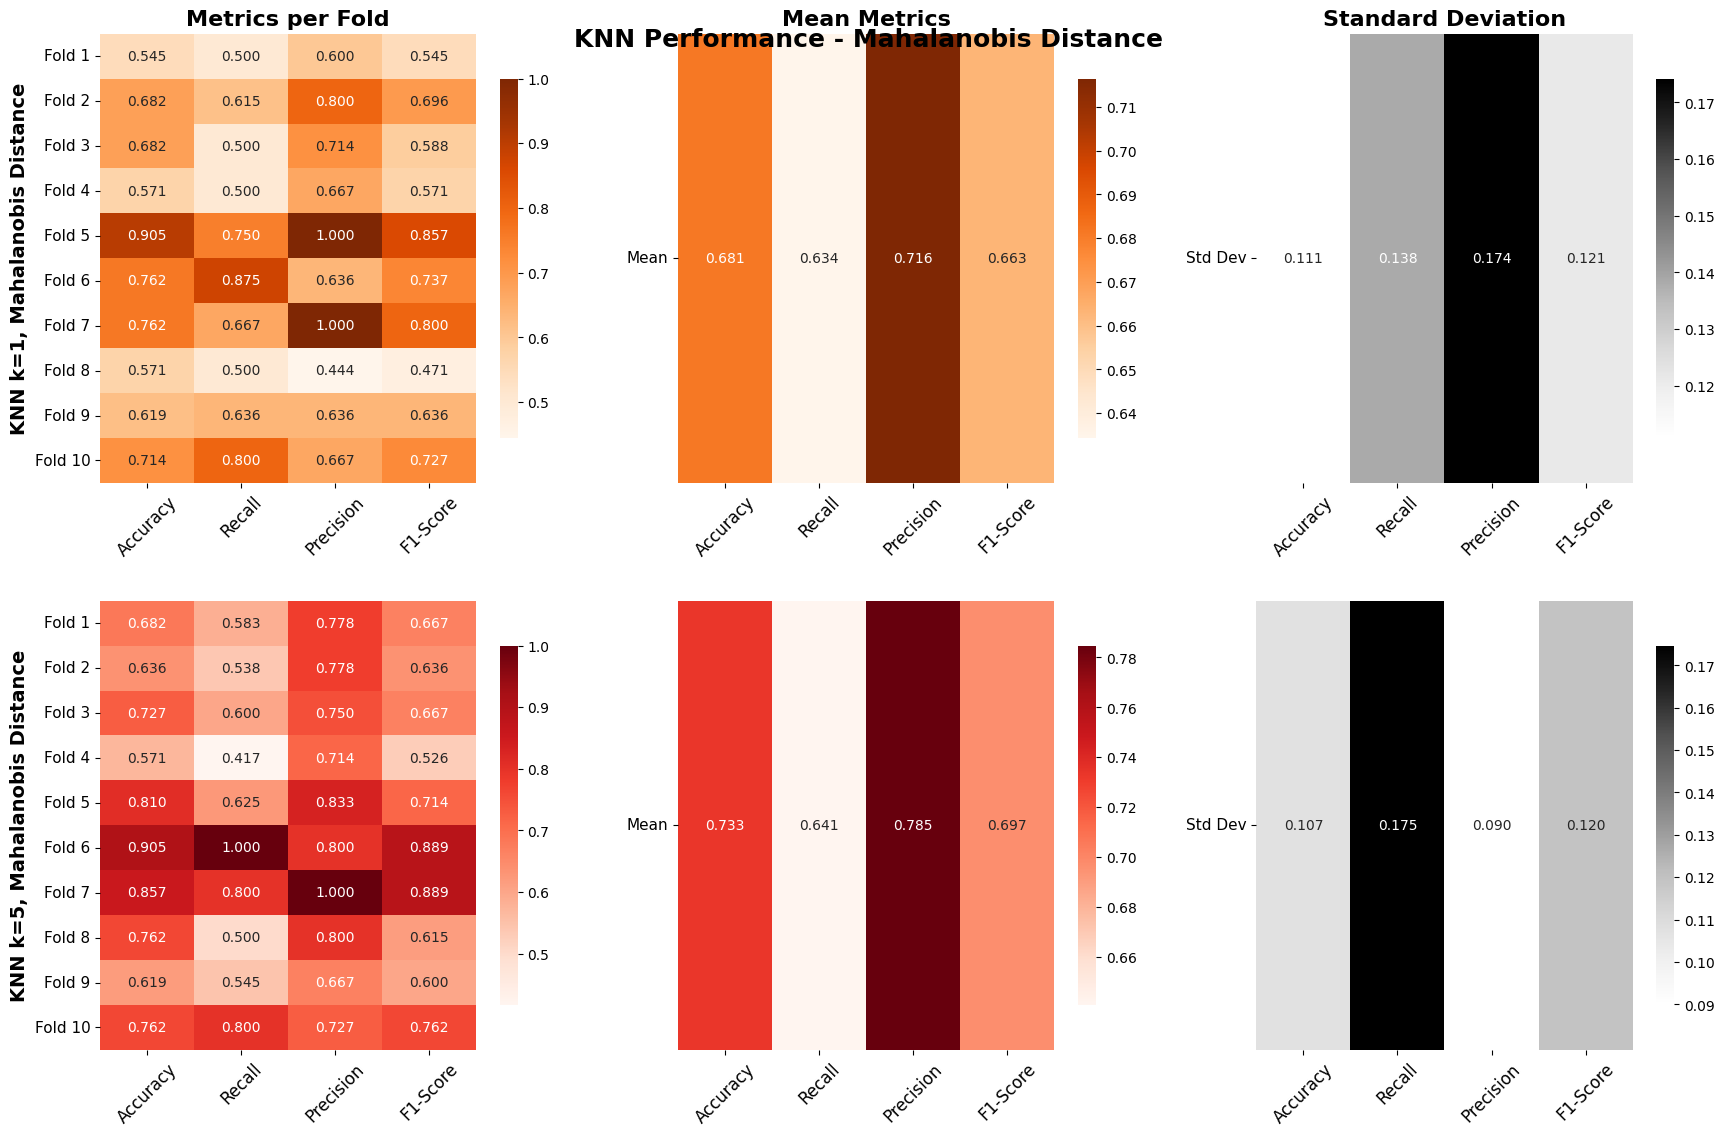

In [131]:
euclidean_labels = [
    'KNN k=1, Euclidean Distance',
    'KNN k=5, Euclidean Distance'
]
euclidean_colors = ['Blues', 'Greens']
create_heatmap(
    metrics_data=metrics[:2],
    model_labels=euclidean_labels,
    colors=euclidean_colors,
    title='KNN Performance - Euclidean Distance'
)

mahalanobis_labels = [
    'KNN k=1, Mahalanobis Distance',
    'KNN k=5, Mahalanobis Distance'
]
mahalanobis_colors = ['Oranges', 'Reds']
create_heatmap(
    metrics_data=metrics[2:],
    model_labels=mahalanobis_labels,
    colors=mahalanobis_colors,
    title='KNN Performance - Mahalanobis Distance'
)

### a.2) Decision Tree

In [132]:
folder = KFold(n_splits=10, shuffle=True)
gini_model = DecisionTreeClassifier(criterion='gini')
entropy_model = DecisionTreeClassifier(criterion='entropy')

In [133]:
dt_models = [gini_model, entropy_model]
dt_metrics = np.zeros((2, 10, 4))

for i, (train_index, test_index) in enumerate(folder.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    _, fold_metrics = evaluate_models(dt_models, X_train, X_test, y_train, y_test)
    
    for j, model_metrics in enumerate(fold_metrics):
        dt_metrics[j][i] = model_metrics

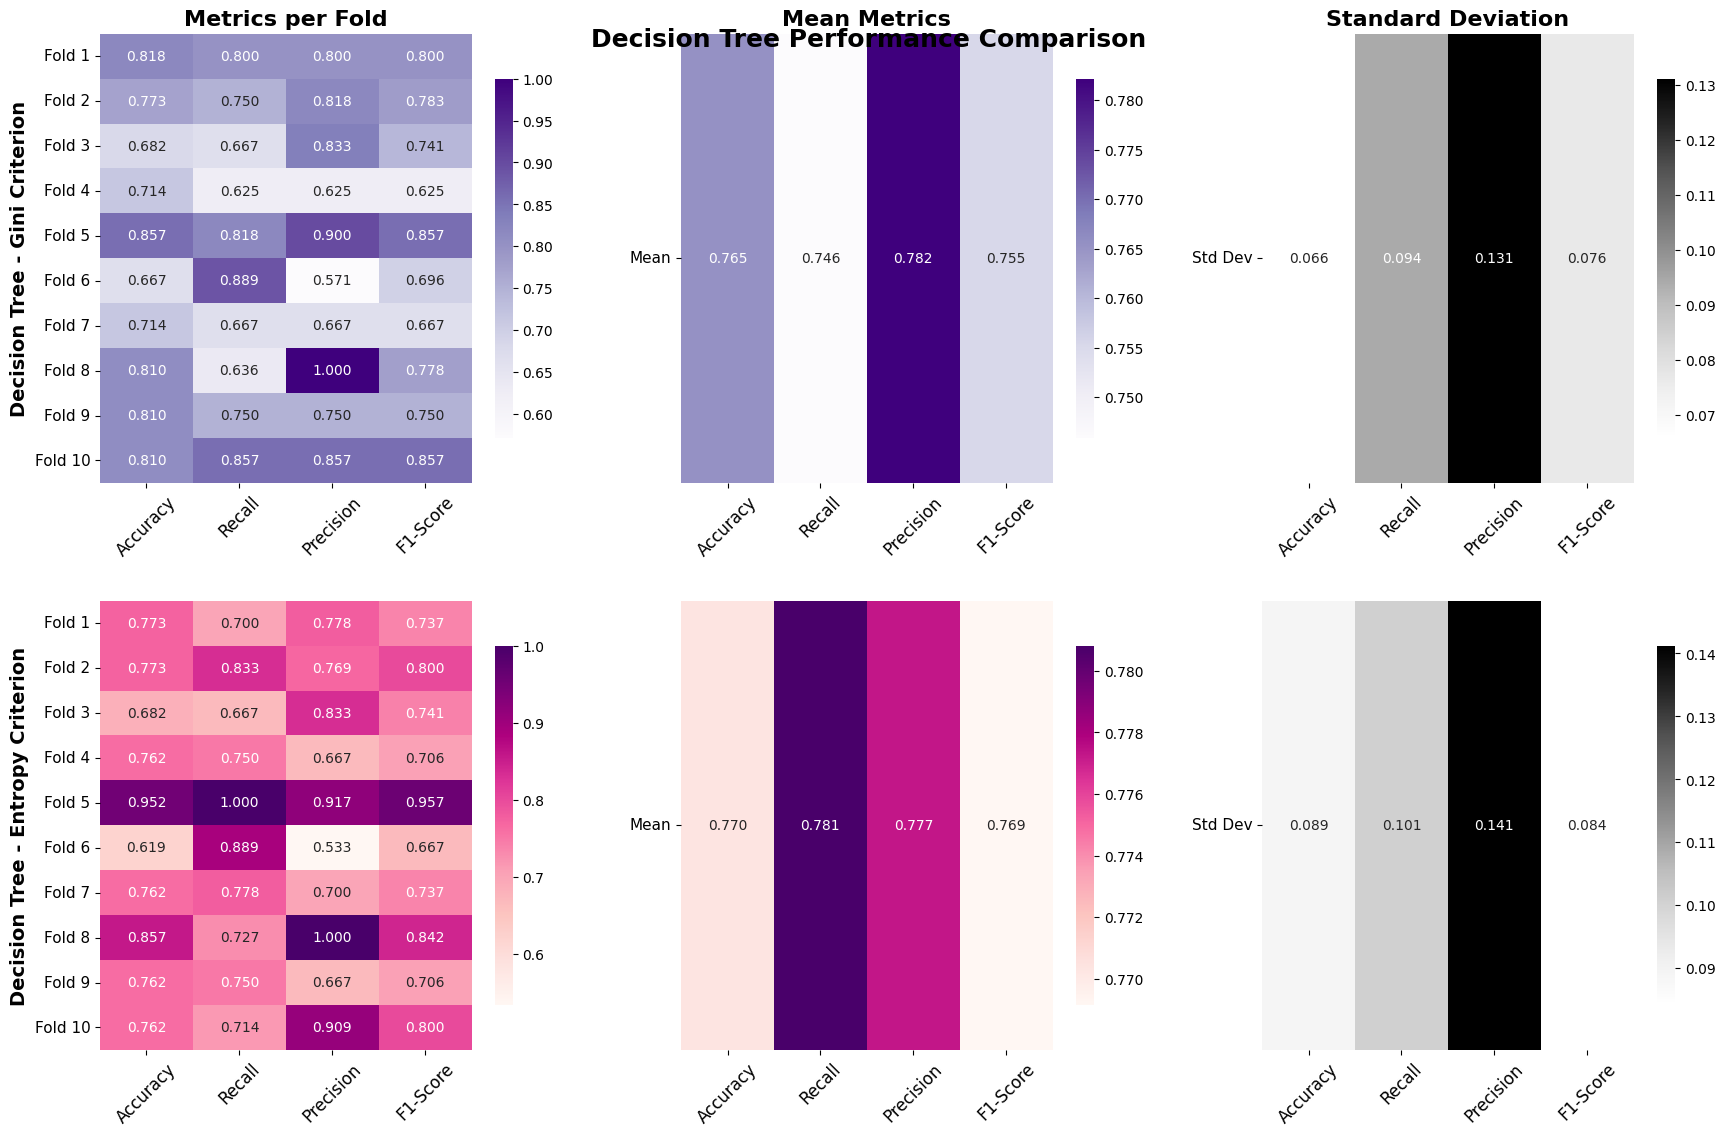

In [134]:
dt_labels = [
    'Decision Tree - Gini Criterion',
    'Decision Tree - Entropy Criterion'
]
dt_colors = ['Purples', 'RdPu']

create_heatmap(
    metrics_data=dt_metrics,
    model_labels=dt_labels,
    colors=dt_colors,
    title='Decision Tree Performance Comparison'
)